# Compute transition numbers for green, brown and neutral occupations
Felix Zaussinger | 20.08.2021

## Core Analysis Goal(s)
1. Map transition pathways based on new G/B/N classification and other proxies

## Key Insight(s)
1.

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [3]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [4]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

In [57]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

df_metadata = df_metadata.set_index("id")

#df_metadata.greenness_vona_2018_v2 = df_metadata.greenness_vona_2018_v2.fillna(0)

# convert job zone to categorical var
#df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)
#df_metadata.isco_level_1 = pd.Categorical(df_metadata.isco_level_1, ordered=False)
#df_metadata.isco_level_2 = pd.Categorical(df_metadata.isco_level_2, ordered=False)

In [6]:
# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

np.fill_diagonal(sim_kanders, 0)

## Determine closest matches based on skill similiarity

In [7]:
# source: https://github.com/nestauk/mapping-career-causeways/blob/main/mapping_career_causeways/compare_nodes_utils.py
def find_closest(i, similarity_matrix, df):
    """
    Method for reporting the closest neighbours to a node i given a similarity matrix;
    useful during exploratory data analysis.
    Parameters
    ----------
    i (int OR None):
        Determines for which node where are assessing the closest neighbours;
        if i==None, a random node is chosen.
    similarity_matrix (numpy.ndarray):
        Similarity matrix determining the closeness between each pair of nodes.
    df (pandas.DataFrame):
        Dataframe to be used for reporting the closest neighbours; must have then
        same number of rows as the similarity matrix
    Returns
    -------
    df (pandas.DataFrame):
        The same input dataframe with an added column for similarity values
        between node i and the rest of the nodes, ordered in a descending order
        of similarity.
    """
    if type(i) == type(None):
        i = np.random.randint(similarity_matrix.shape[0])

    most_similar = np.flip(np.argsort(similarity_matrix[i,:]))
    similarity = np.flip(np.sort(similarity_matrix[i,:]))

    df = df.copy().loc[most_similar]
    df['similarity'] = similarity
    return df

## Iterate over all occupations and identify transition options

In [34]:
VIABLE = 0.3
HIGHLY_VIABLE = 0.4
EARNINGS_RATIO = 0.75
JOB_ZONE_DELTA = 1

In [125]:
transition_numbers_all = {}
df_occ = pd.DataFrame(occ.conceptUri.values, columns=["conceptUri"])

# iterate over mining occupations
for i in tqdm(df_metadata.index.values):

    # find closest occupations
    sim_ranking = find_closest(
        i=i,
        similarity_matrix=sim_kanders,
        df=df_occ
    )

    # print source occupation
    source_occ = df_metadata.iloc[i, :]
    #print("Source occupation: {}".format(source_occ.preferred_label))

    # merge metadata
    result = pd.merge(
        sim_ranking,
        df_metadata[[
            "concept_uri",
            "preferred_label",
            "annual_earnings",
            "is_brown",
            "is_green",
            "is_neutral",
            "job_zone"
        ]],
        left_on="conceptUri",
        right_on="concept_uri",
        how="left"
    ).drop(columns=["concept_uri"], axis=1)

    # add transitions metadata
    result["job_zone_delta"] = np.abs(source_occ.job_zone - result.job_zone)
    result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings

    result["is_viable"] = (result.similarity >= VIABLE) & (result.job_zone_delta <= JOB_ZONE_DELTA)
    result["is_highly_viable"] = (result.similarity >= HIGHLY_VIABLE)  & (result.job_zone_delta <= JOB_ZONE_DELTA)
    result["is_desirable"] = result.is_viable & (result.earnings_ratio >= EARNINGS_RATIO)
    result["is_highly_desirable"] = result.is_highly_viable & (result.earnings_ratio >= EARNINGS_RATIO)
    #result["is_green"] = result.greenness_vona_2018_v2 > 0
    #result["is_neutral"] = (result.greenness_vona_2018_v2 == 0) & (result.is_brown == False)

    # viable transitions by gbn
    result["is_viable_brown"] = result.is_viable & (result.is_brown == True)
    result["is_viable_neutral"] = result.is_viable & (result.is_neutral == True)
    result["is_viable_green"] = result.is_viable & (result.is_green == True)

    # highly viable transitions by gbn
    result["is_highly_viable_brown"] = result.is_highly_viable & (result.is_brown == True)
    result["is_highly_viable_neutral"] = result.is_highly_viable & (result.is_neutral == True)
    result["is_highly_viable_green"] = result.is_highly_viable & (result.is_green == True)

    # desirable transitions by gbn
    result["is_desirable_brown"] = result.is_desirable & (result.is_brown == True)
    result["is_desirable_neutral"] = result.is_desirable & (result.is_neutral == True)
    result["is_desirable_green"] = result.is_desirable & (result.is_green == True)

    # highly desirable transitions by gbn
    result["is_highly_desirable_brown"] = result.is_highly_desirable & (result.is_brown == True)
    result["is_highly_desirable_neutral"] = result.is_highly_desirable & (result.is_neutral == True)
    result["is_highly_desirable_green"] = result.is_highly_desirable & (result.is_green == True)

    # subset to viable transitions
    result_subset = result[result.is_viable == True]

    # subset to boolean cols
    boolean_cols = [
        'is_viable', 'is_highly_viable', 'is_desirable', 'is_highly_desirable',
        'is_viable_brown', 'is_viable_neutral', 'is_viable_green',
        'is_highly_viable_brown', 'is_highly_viable_neutral', 'is_highly_viable_green',
        'is_desirable_brown', 'is_desirable_neutral', 'is_desirable_green',
        'is_highly_desirable_brown', 'is_highly_desirable_neutral', 'is_highly_desirable_green'
    ]

    # subset to viable transitions only
    result_subset_bools = result_subset[boolean_cols]

    # count True's per boolean column
    s_sum = result_subset_bools.sum()

    transition_numbers_all[i] = s_sum

100%|██████████| 2942/2942 [01:02<00:00, 46.89it/s]


In [126]:
# to df
cols_merge = ["preferred_label", "isco_level_1"] #, "annual_earnings", "education_level", "related_work_experience", "on_the_job_training"]
df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled = pd.concat(
    [df_metadata[cols_merge], df_transition_numbers_all], axis=1
)

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_viable_brown,is_viable_neutral,is_viable_green,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green
0,19,0,18,0,0,17,2,0,0,0,0,16,2,0,0,0
1,174,123,174,123,101,63,10,74,46,3,101,63,10,74,46,3
2,250,60,249,60,83,126,41,10,24,26,83,126,40,10,24,26
3,62,2,57,2,1,51,10,0,2,0,1,49,7,0,2,0
4,217,13,200,12,2,143,72,0,11,2,2,130,68,0,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,79,36,72,33,1,54,24,1,26,9,1,50,21,1,25,7
2938,10,3,9,3,2,3,5,0,0,3,1,3,5,0,0,3
2939,36,16,32,16,1,34,1,0,16,0,1,30,1,0,16,0
2940,44,3,23,2,0,39,5,0,3,0,0,18,5,0,2,0


In [15]:
# rename binary identifier column to avoid confusion with transition number col
df_metadata = df_metadata.rename(columns={"is_brown": "brown"})

# delineate "neutral" occupations as those that are non-green and non-mining
df_metadata["neutral"] = (df_metadata.greenness_vona_2018_v2 == 0) & (df_metadata.brown == False)

# bool for green occupations
df_metadata["green"] = (df_metadata.greenness_vona_2018_v2 > 0)

In [127]:
# merge transition numbers to all the other metadata, export csv
df_metadata_transitions = pd.concat(
    [df_metadata, df_transition_numbers_all], axis=1
)

df_metadata_transitions.to_csv(
    os.path.join(data_interim, "esco_onet_metadata_transition_numbers_v2.csv")
)

#### Scatterplot: growth delta vs transition numbers

<AxesSubplot:xlabel='is_viable', ylabel='net_change_ilo_2030_es'>

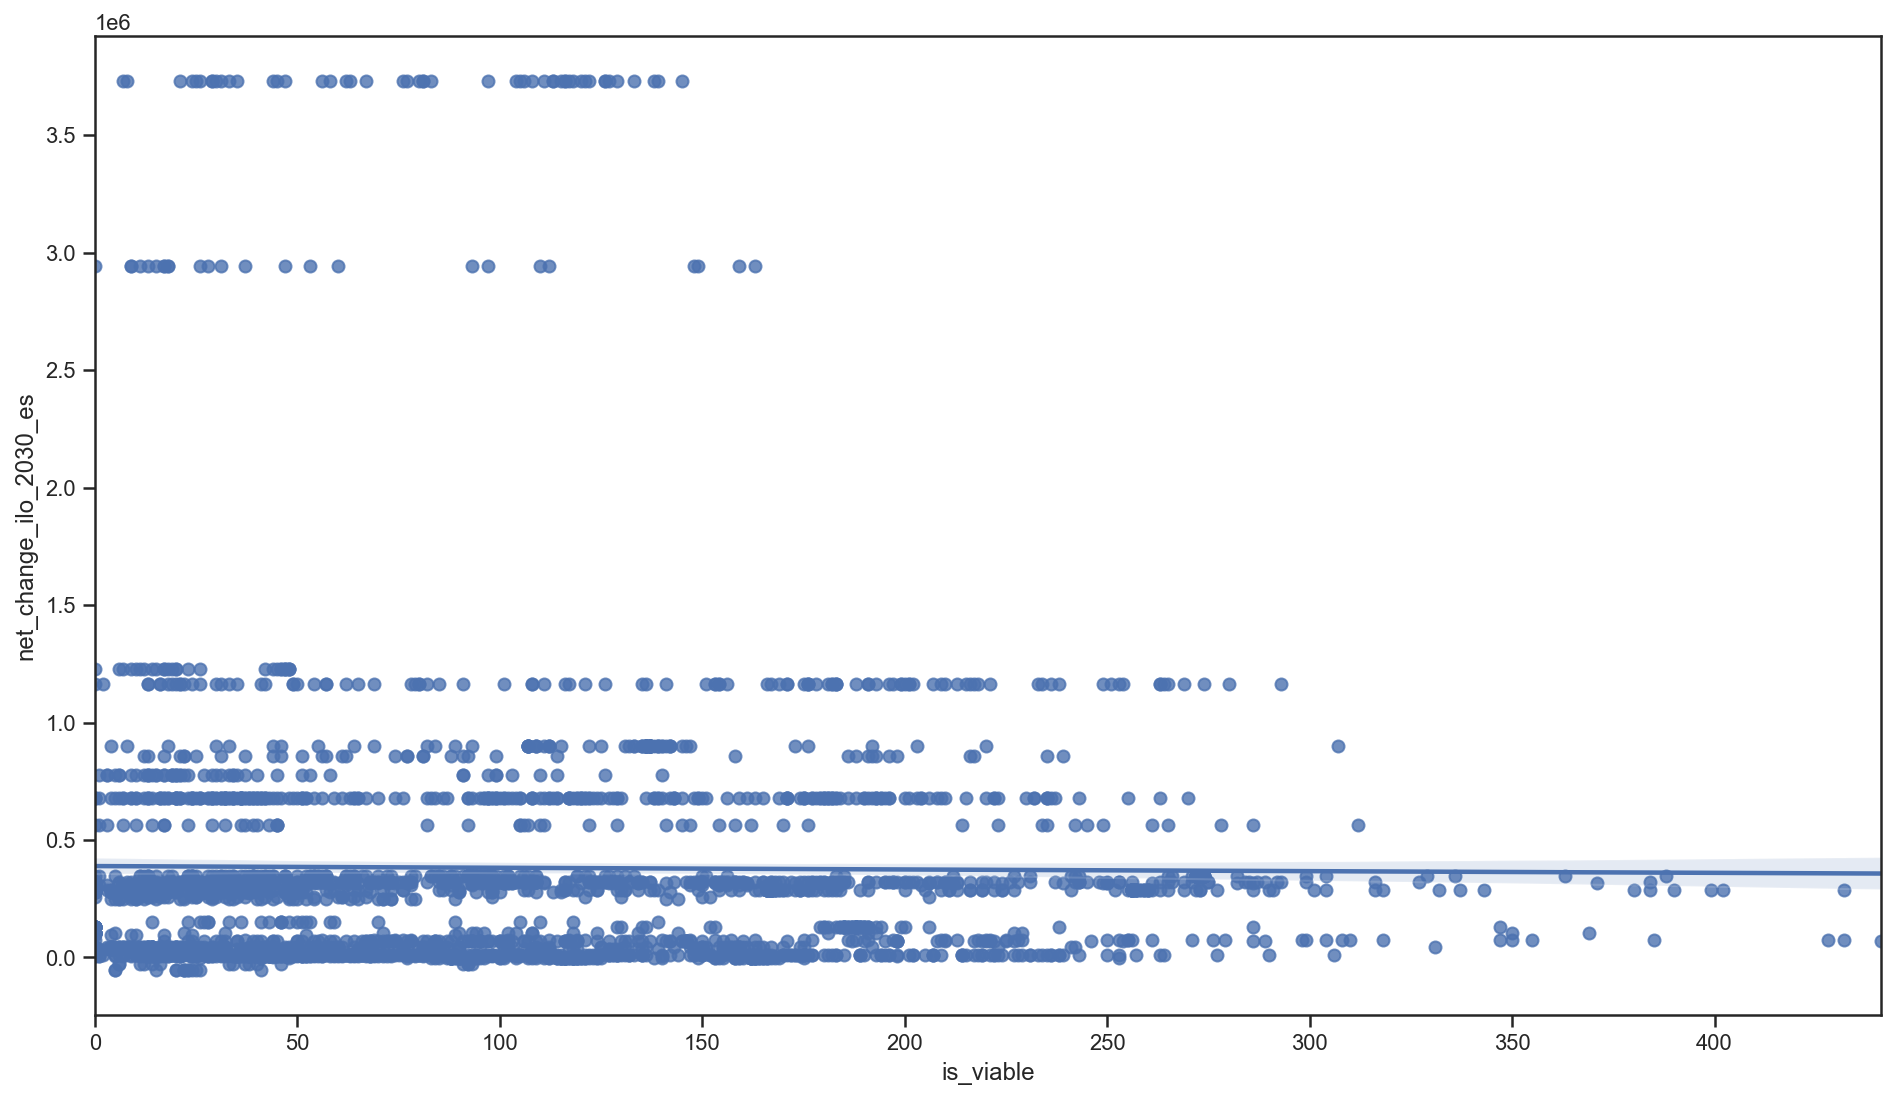

In [129]:
sns.regplot(
    data=df_metadata_transitions,
    x="is_viable",
    y="net_change_ilo_2030_es"
)

## Visualise transition numbers for all occupations

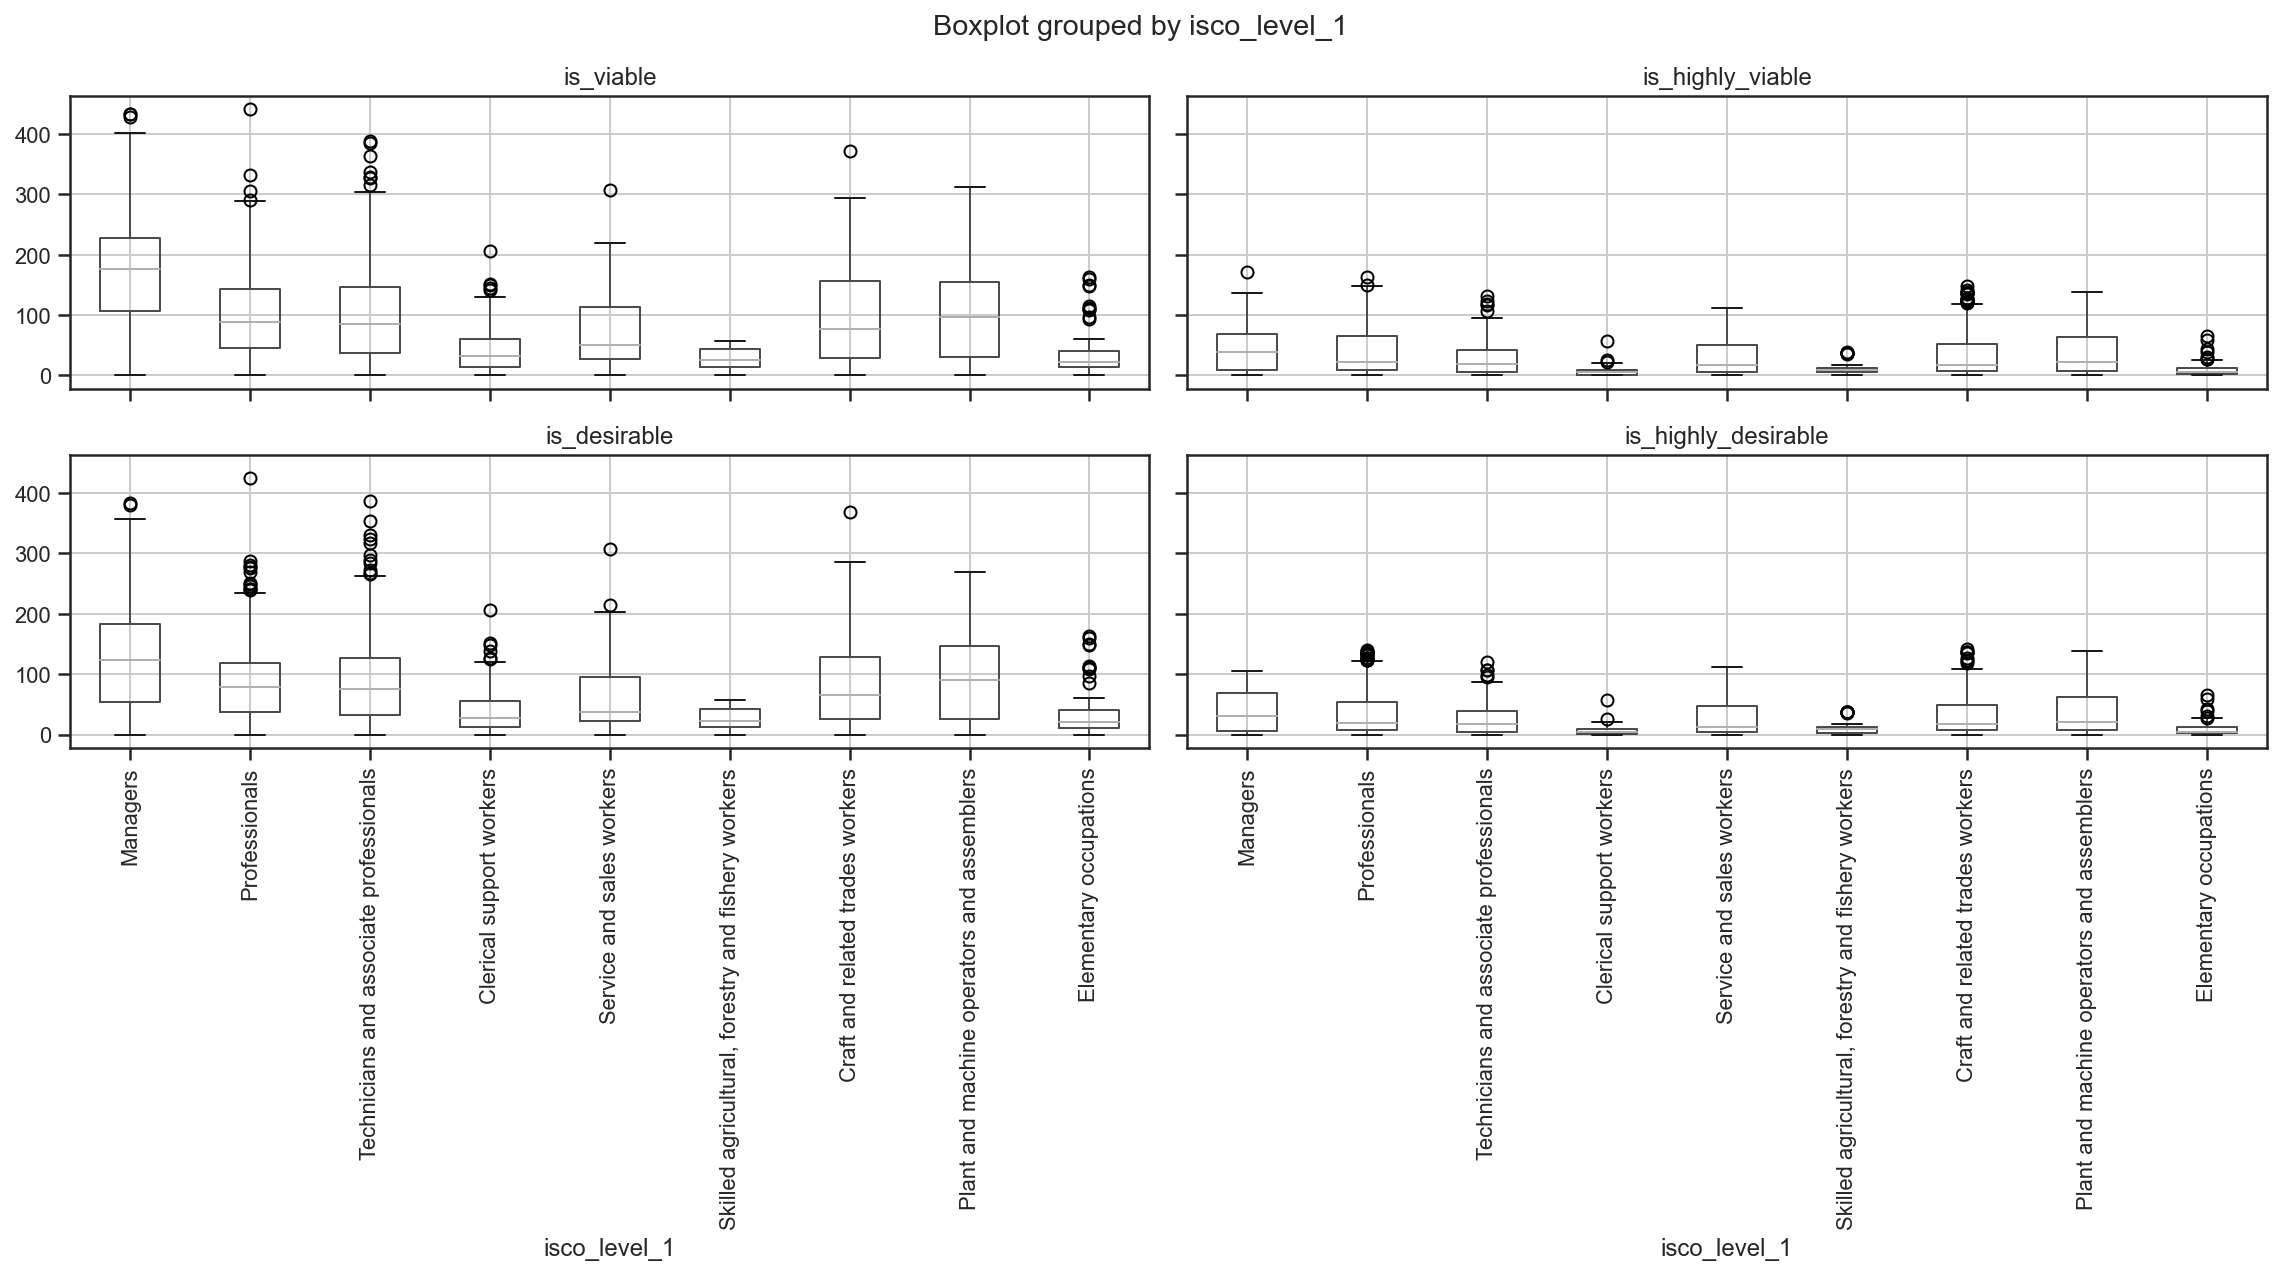

In [81]:
# boxplots of transition numbers by isco lvl 1 groups
isco_lvl1_mapping = {
    1: "Managers",
    2: "Professionals",
    3: "Technicians and associate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural, forestry and fishery workers",
    7: "Craft and related trades workers",
    8: "Plant and machine operators and assemblers",
    9: "Elementary occupations"
}

df_transition_numbers_all_labelled.boxplot(
    column=["is_viable", "is_highly_viable", "is_desirable", "is_highly_desirable"],
    by="isco_level_1",
    layout=(2,2),
    rot=90
)

plt.xticks(np.arange(1,10), list(isco_lvl1_mapping.values()))

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_isco_lvl1_v2.png"),
    dpi=150,
    bbox_inches="tight"
)

In [18]:
df_transition_numbers_all_labelled

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_brown,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1
0,19,0,18,0,2,17,0,0,0,0,0,16,2,0,0,0,technical director,2
1,174,123,174,123,11,163,0,0,119,4,0,163,11,0,119,4,metal drawing machine operator,8
2,250,60,249,60,41,207,2,0,34,26,2,207,40,0,34,26,precision device inspector,7
3,62,2,57,2,10,52,0,0,2,0,0,50,7,0,2,0,air traffic safety technician,3
4,217,13,200,12,72,144,1,0,11,2,1,131,68,0,10,2,hospitality revenue manager,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,79,36,72,33,24,55,0,0,27,9,0,51,21,0,26,7,demographer,2
2938,10,3,9,3,5,5,0,0,0,3,0,4,5,0,0,3,sorter labourer,9
2939,36,16,32,16,1,35,0,0,16,0,0,31,1,0,16,0,armoured car guard,5
2940,44,3,23,2,5,39,0,0,3,0,0,18,5,0,2,0,civil service administrative officer,2


In [130]:
# Visualise differences in transition options to neutral, green and mining
# occupations

value_vars = list(filter(None, [col_label if "is_" in col_label else None for col_label in df_transition_numbers_all_labelled.columns]))
df_ntrans_long = df_transition_numbers_all_labelled.melt(
    value_vars=value_vars,
    id_vars=['preferred_label', 'isco_level_1'],
    var_name="Target"
)

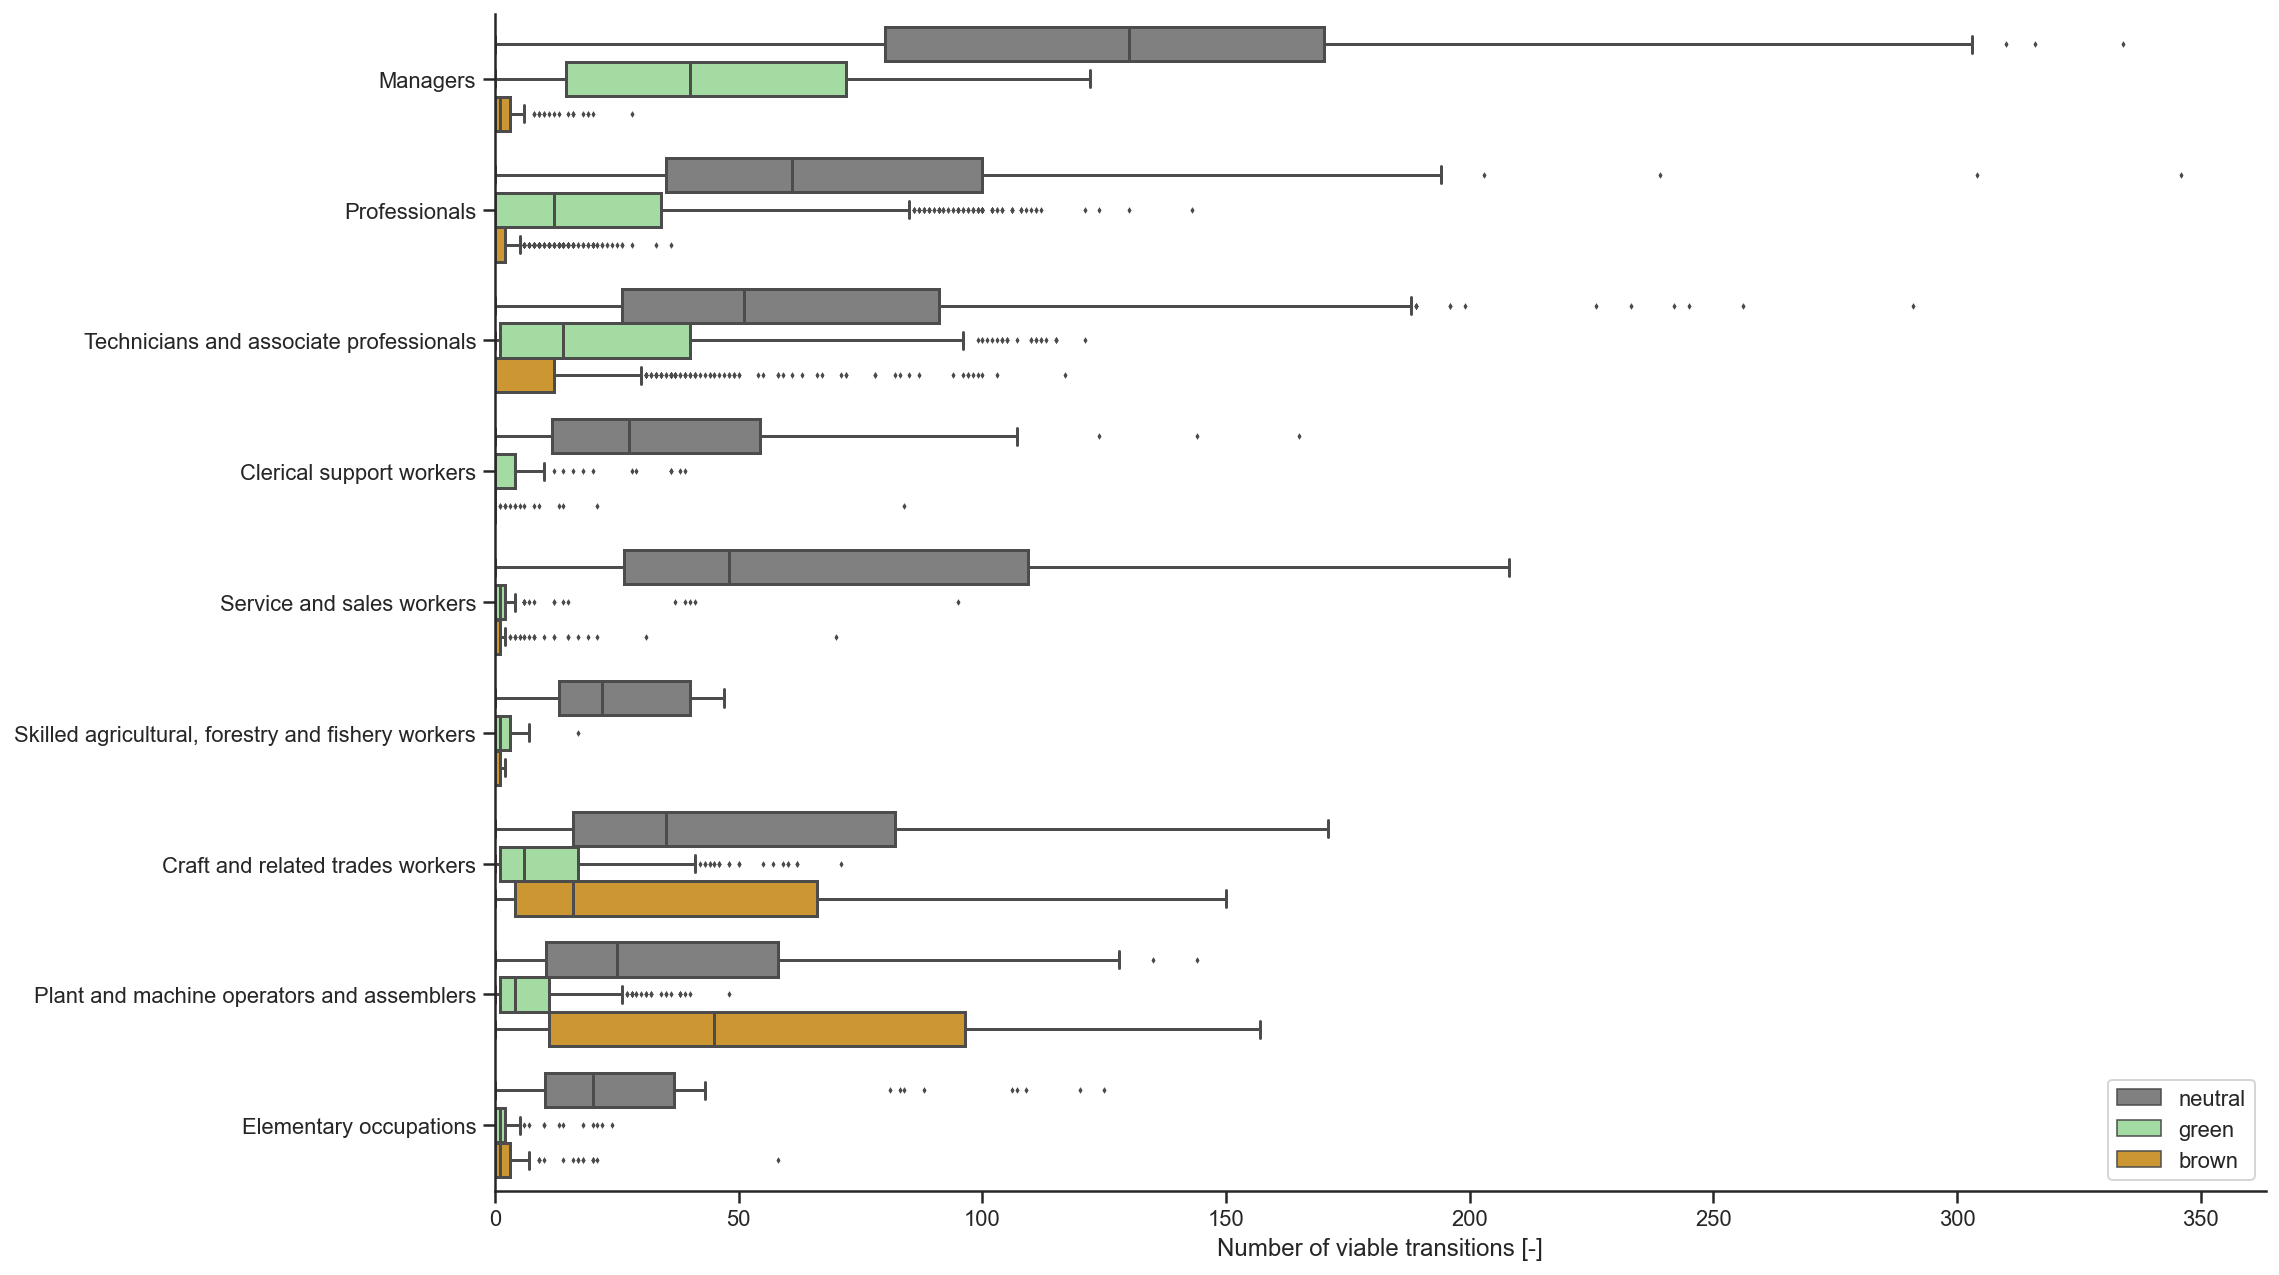

In [131]:
# viable
df_ntrans_long_is_viable = df_ntrans_long.query("Target == 'is_viable_brown' or Target == 'is_viable_neutral' or Target == 'is_viable_green'")
replace_dict = {"Target": {"is_viable_green": "green", "is_viable_neutral": "neutral", "is_viable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_viable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of viable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_viable_composition_isco_lvl1_v2.png"),
    dpi=150,
    bbox_inches="tight"
)

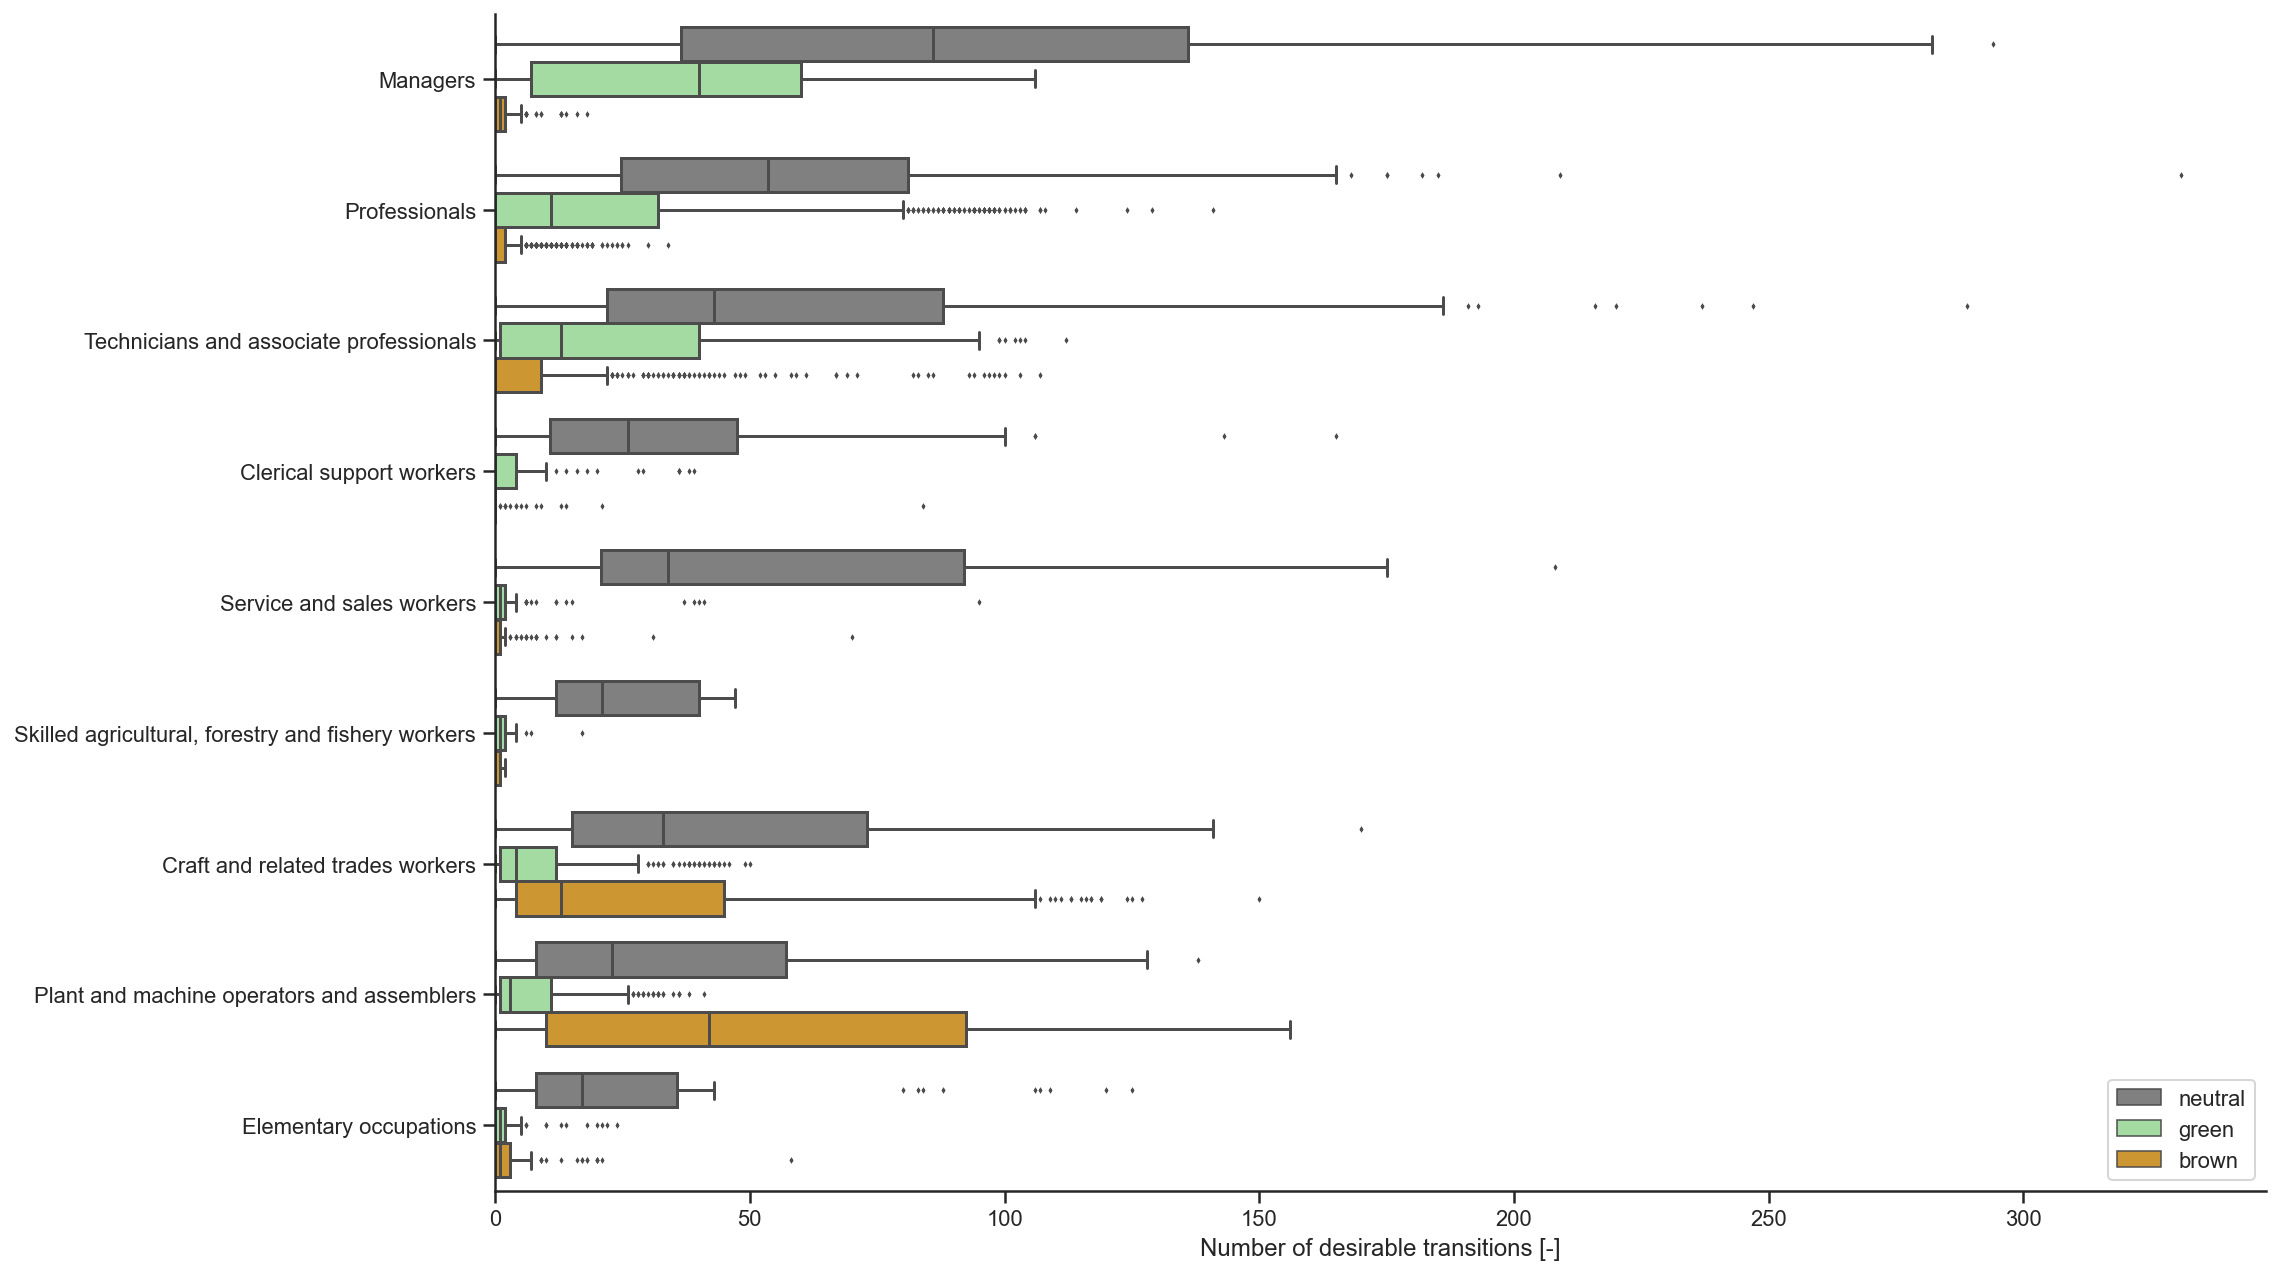

In [111]:
# desirable
df_ntrans_long_is_desirable = df_ntrans_long.query("Target == 'is_desirable_brown' or Target == 'is_desirable_neutral' or Target == 'is_desirable_green'")
replace_dict = {"Target": {"is_desirable_green": "green", "is_desirable_neutral": "neutral", "is_desirable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_desirable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of desirable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_desirable_composition_isco_lvl1_v2.png"),
    dpi=150,
    bbox_inches="tight"
)

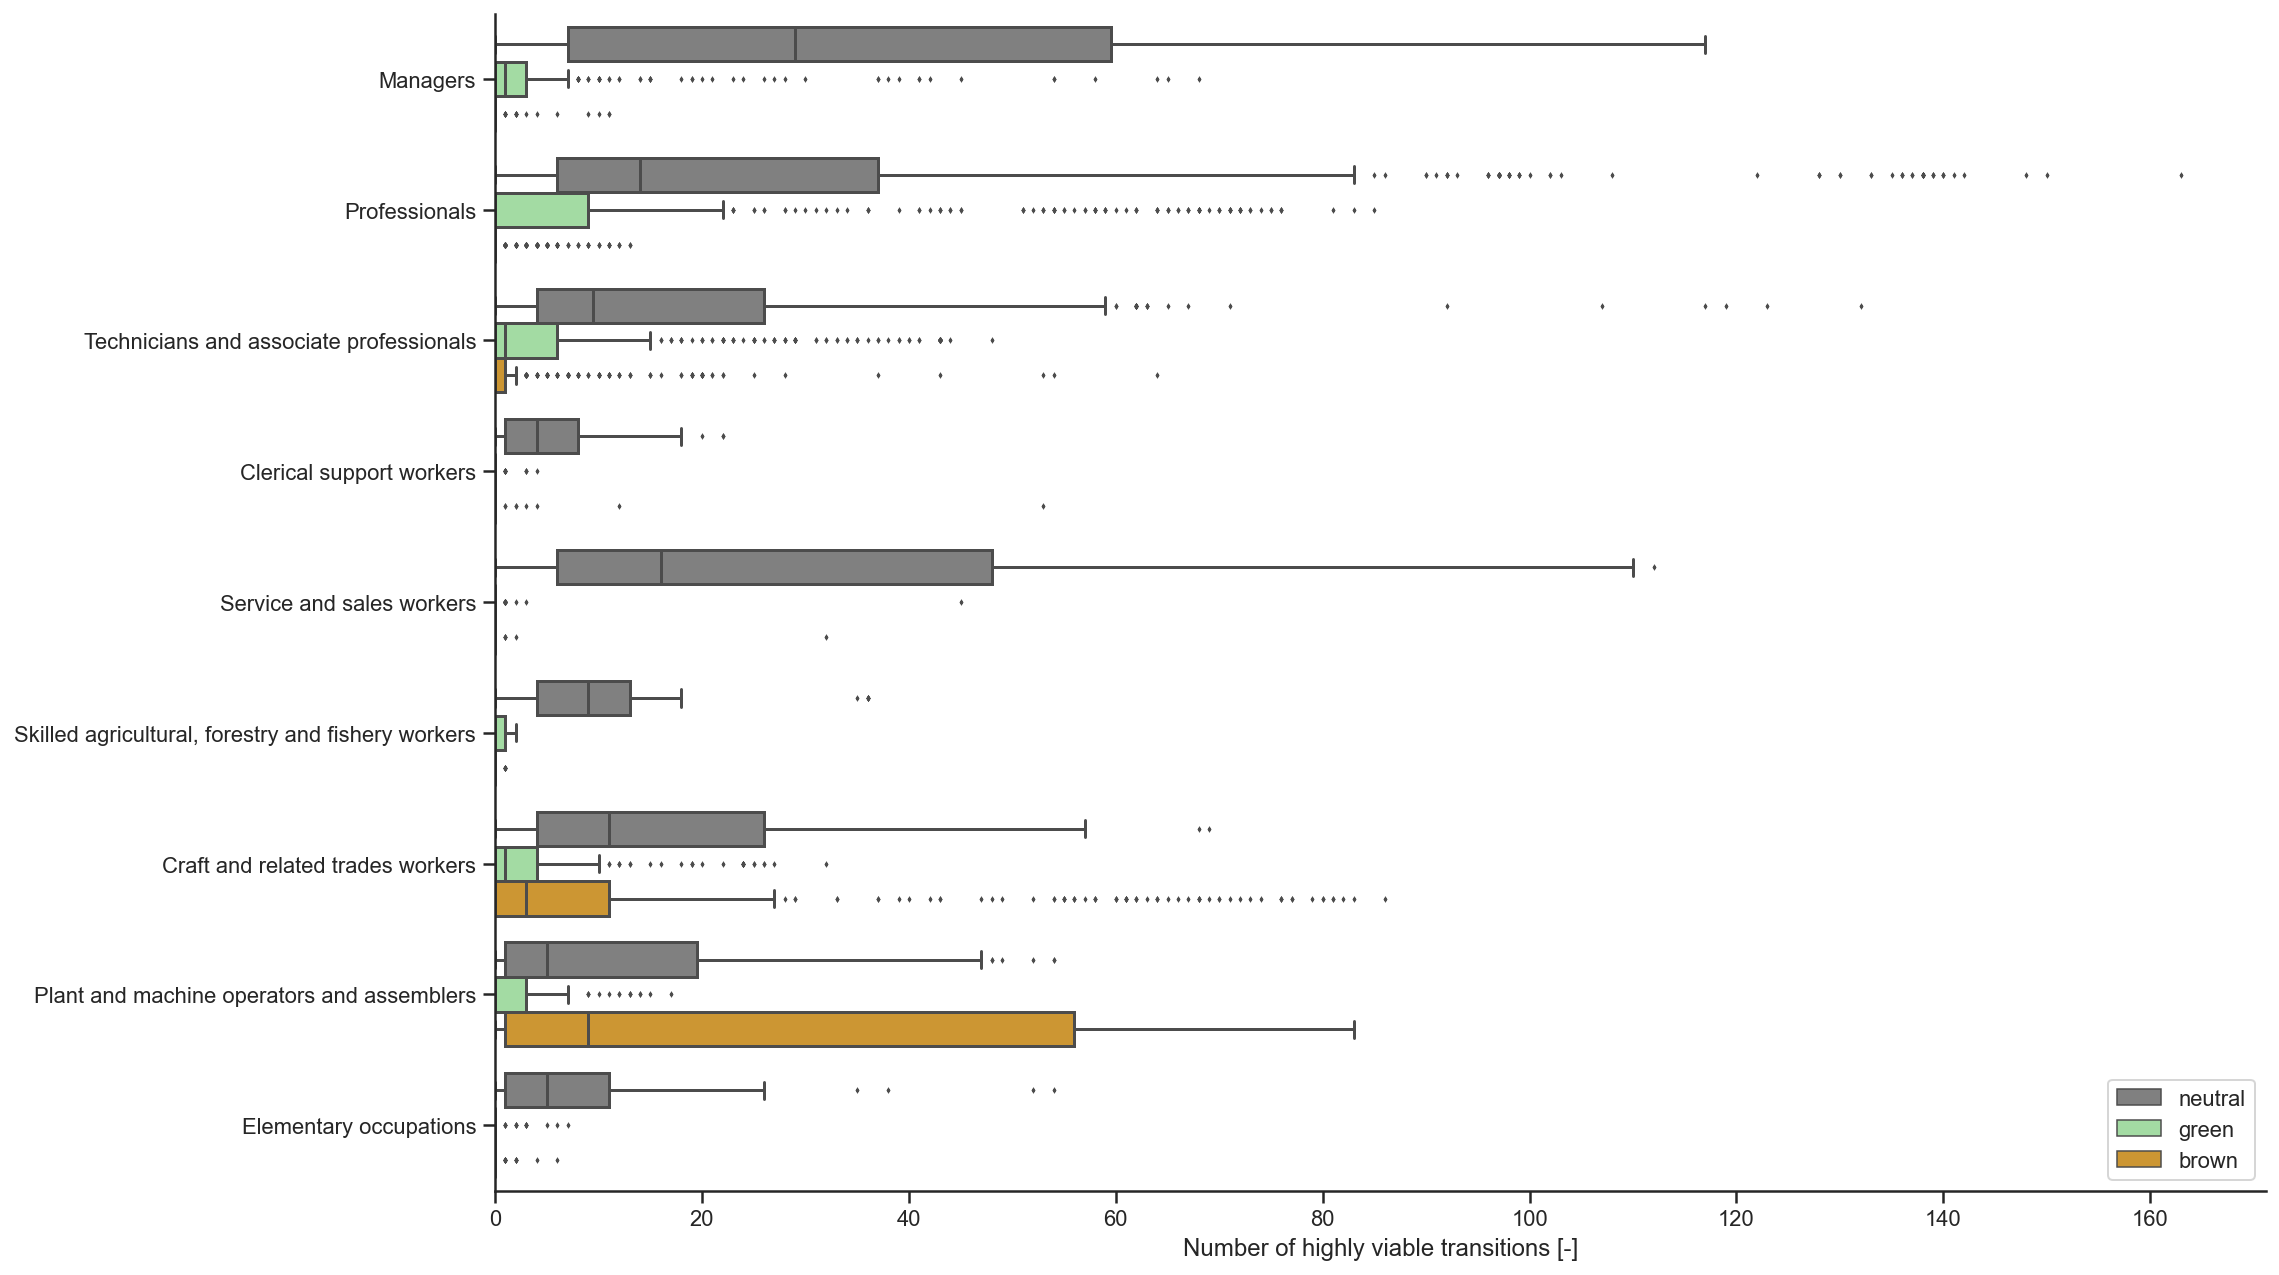

In [109]:
# highly viable
df_ntrans_long_is_highly_viable = df_ntrans_long.query("Target == 'is_highly_viable_brown' or Target == 'is_highly_viable_neutral' or Target == 'is_highly_viable_green'")
replace_dict = {"Target": {"is_highly_viable_green": "green", "is_highly_viable_neutral": "neutral", "is_highly_viable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_viable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of highly viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly viable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_highly_viable_composition_isco_lvl1_v2.png"),
    dpi=150,
    bbox_inches="tight"
)

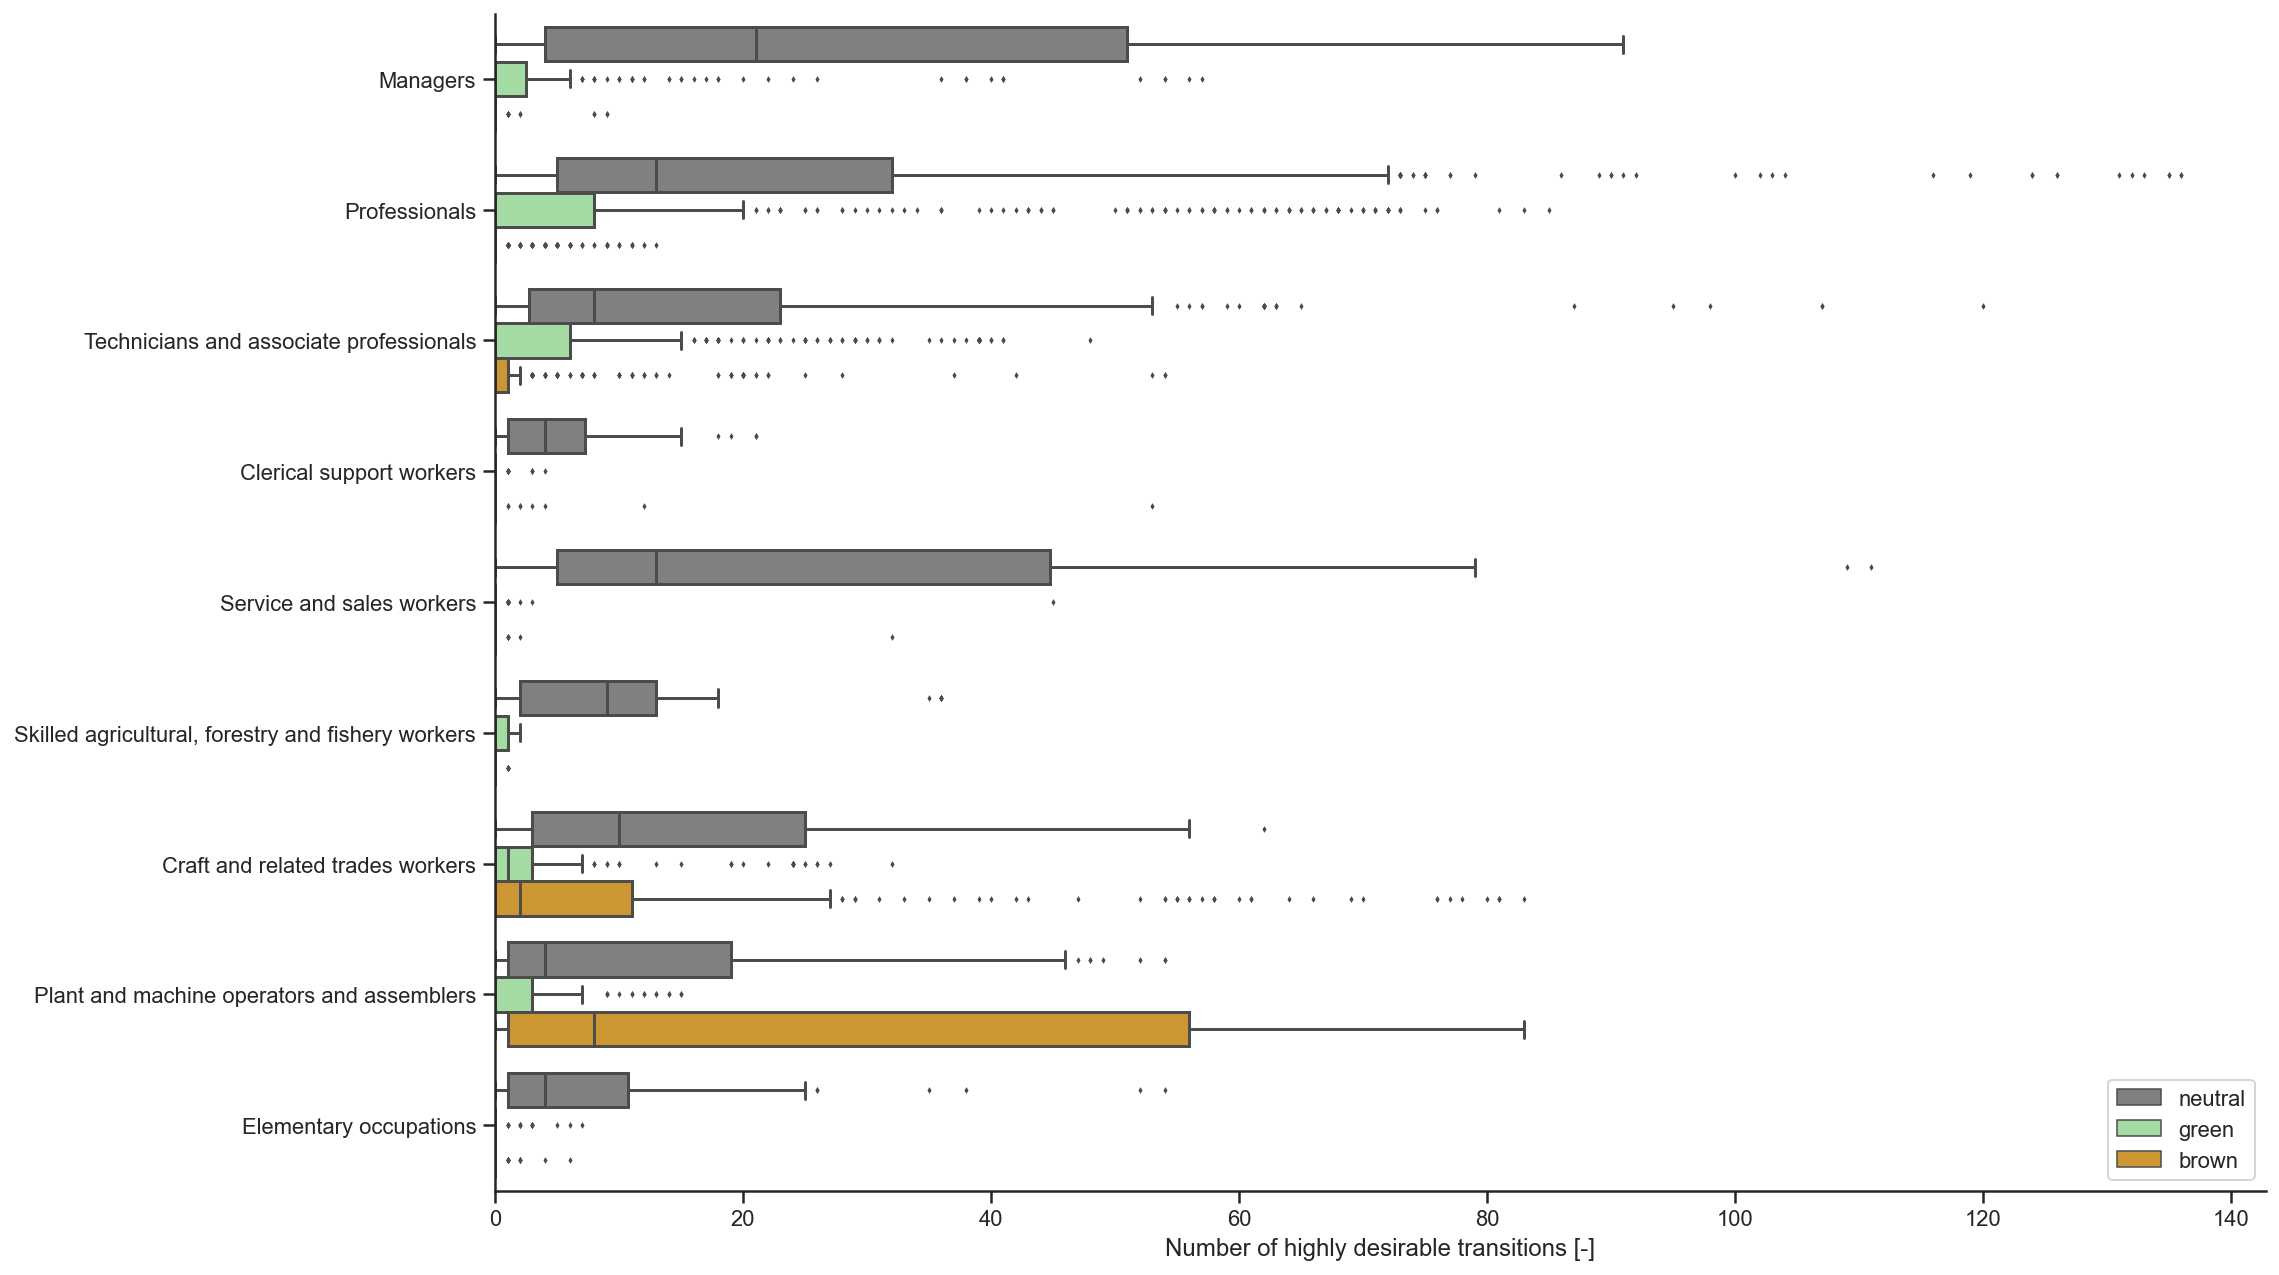

In [110]:
df_ntrans_long_is_highly_desirable = df_ntrans_long.query("Target == 'is_highly_desirable_brown' or Target == 'is_highly_desirable_neutral' or Target == 'is_highly_desirable_green'")
replace_dict = {"Target": {"is_highly_desirable_green": "green", "is_highly_desirable_neutral": "neutral", "is_highly_desirable_brown": "brown"}}

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="Target",
    hue_order=["neutral", "green", "brown"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_desirable.replace(replace_dict)
)

ax.set_xlim(0)
plt.legend(loc="lower right")
#ax.set_title("Composition of highly desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly desirable transitions [-]")
ax.set_ylabel(None)
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_highly_desirable_composition_isco_lvl1_v2.png"),
    dpi=150,
    bbox_inches="tight"
)

## Regression analysis of transition numbers

In [112]:
# to df
cols_merge = ["preferred_label", "isco_level_1", "annual_earnings", "education_level", "related_work_experience", "on_the_job_training", "job_zone"]
# df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled_wide = pd.concat(
    [df_transition_numbers_all, df_metadata[cols_merge]], axis=1
)

df_transition_numbers_all_labelled_wide

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_brown,is_highly_viable_brown,is_highly_viable_neutral,is_highly_viable_green,is_desirable_brown,is_desirable_neutral,is_desirable_green,is_highly_desirable_brown,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1,annual_earnings,education_level,related_work_experience,on_the_job_training,job_zone
0,19,0,18,0,2,17,0,0,0,0,0,16,2,0,0,0,technical director,2,37555.308176,6.2477,8.0309,4.3843,4.0
1,174,123,174,123,10,63,101,74,46,3,101,63,10,74,46,3,metal drawing machine operator,8,22031.963636,2.1163,2.4383,3.6486,2.0
2,250,60,249,60,41,126,83,10,24,26,83,126,40,10,24,26,precision device inspector,7,22430.367647,2.5397,4.8863,4.0288,2.0
3,62,2,57,2,10,51,1,0,2,0,1,49,7,0,2,0,air traffic safety technician,3,32754.000000,4.3848,5.4808,4.0782,3.0
4,217,13,200,12,72,143,2,0,11,2,2,130,68,0,10,2,hospitality revenue manager,2,38839.816377,6.8261,6.3481,3.8265,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,79,36,72,33,24,54,1,1,26,9,1,50,21,1,25,7,demographer,2,36135.290249,8.3000,5.5000,4.6000,5.0
2938,10,3,9,3,5,3,2,0,0,3,1,3,5,0,0,3,sorter labourer,9,21357.054545,3.1532,3.3559,2.8314,2.0
2939,36,16,32,16,1,34,1,0,16,0,1,30,1,0,16,0,armoured car guard,5,24315.540984,2.2215,3.2642,2.0230,2.0
2940,44,3,23,2,5,39,0,0,3,0,0,18,5,0,2,0,civil service administrative officer,2,33292.986333,3.9636,6.9711,3.4248,3.0


In [132]:
from stargazer.stargazer import Stargazer

df_transition_numbers_all_labelled_wide["is_green_ratio"] = \
    df_transition_numbers_all_labelled_wide["is_green"] / df_transition_numbers_all_labelled_wide["is_viable"]

reg_greenness = ols(
    formula="is_green_ratio ~ annual_earnings + education_level + related_work_experience + on_the_job_training + job_zone + C(isco_level_1)",
    data=df_transition_numbers_all_labelled_wide
).fit(cov_type='HC3')

Stargazer([reg_greenness])


#### How do the transition numbers vary between green, neutral and brown occupations?

In [133]:
# ["brown", "neutral", "green"]
df_metadata_transitions2 = df_metadata_transitions.copy()

df_metadata_transitions2["occ_type"] = df_metadata_transitions2[["is_brown", "is_neutral", "is_green"]].idxmax(axis=1)

In [135]:
df_metadata_transitions2_long = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_viable", "is_desirable", "is_highly_viable", "is_highly_desirable"],
    value_name="transitions",
    var_name="transition_category"
)

,occ_type,transition_category,transitions
0,is_neutral,is_viable,19
1,is_brown,is_viable,174
2,is_green,is_viable,250
3,is_neutral,is_viable,62
4,is_neutral,is_viable,217
...,...,...,...
11763,is_neutral,is_highly_desirable,33
11764,is_green,is_highly_desirable,3
11765,is_neutral,is_highly_desirable,16
11766,is_neutral,is_highly_desirable,2


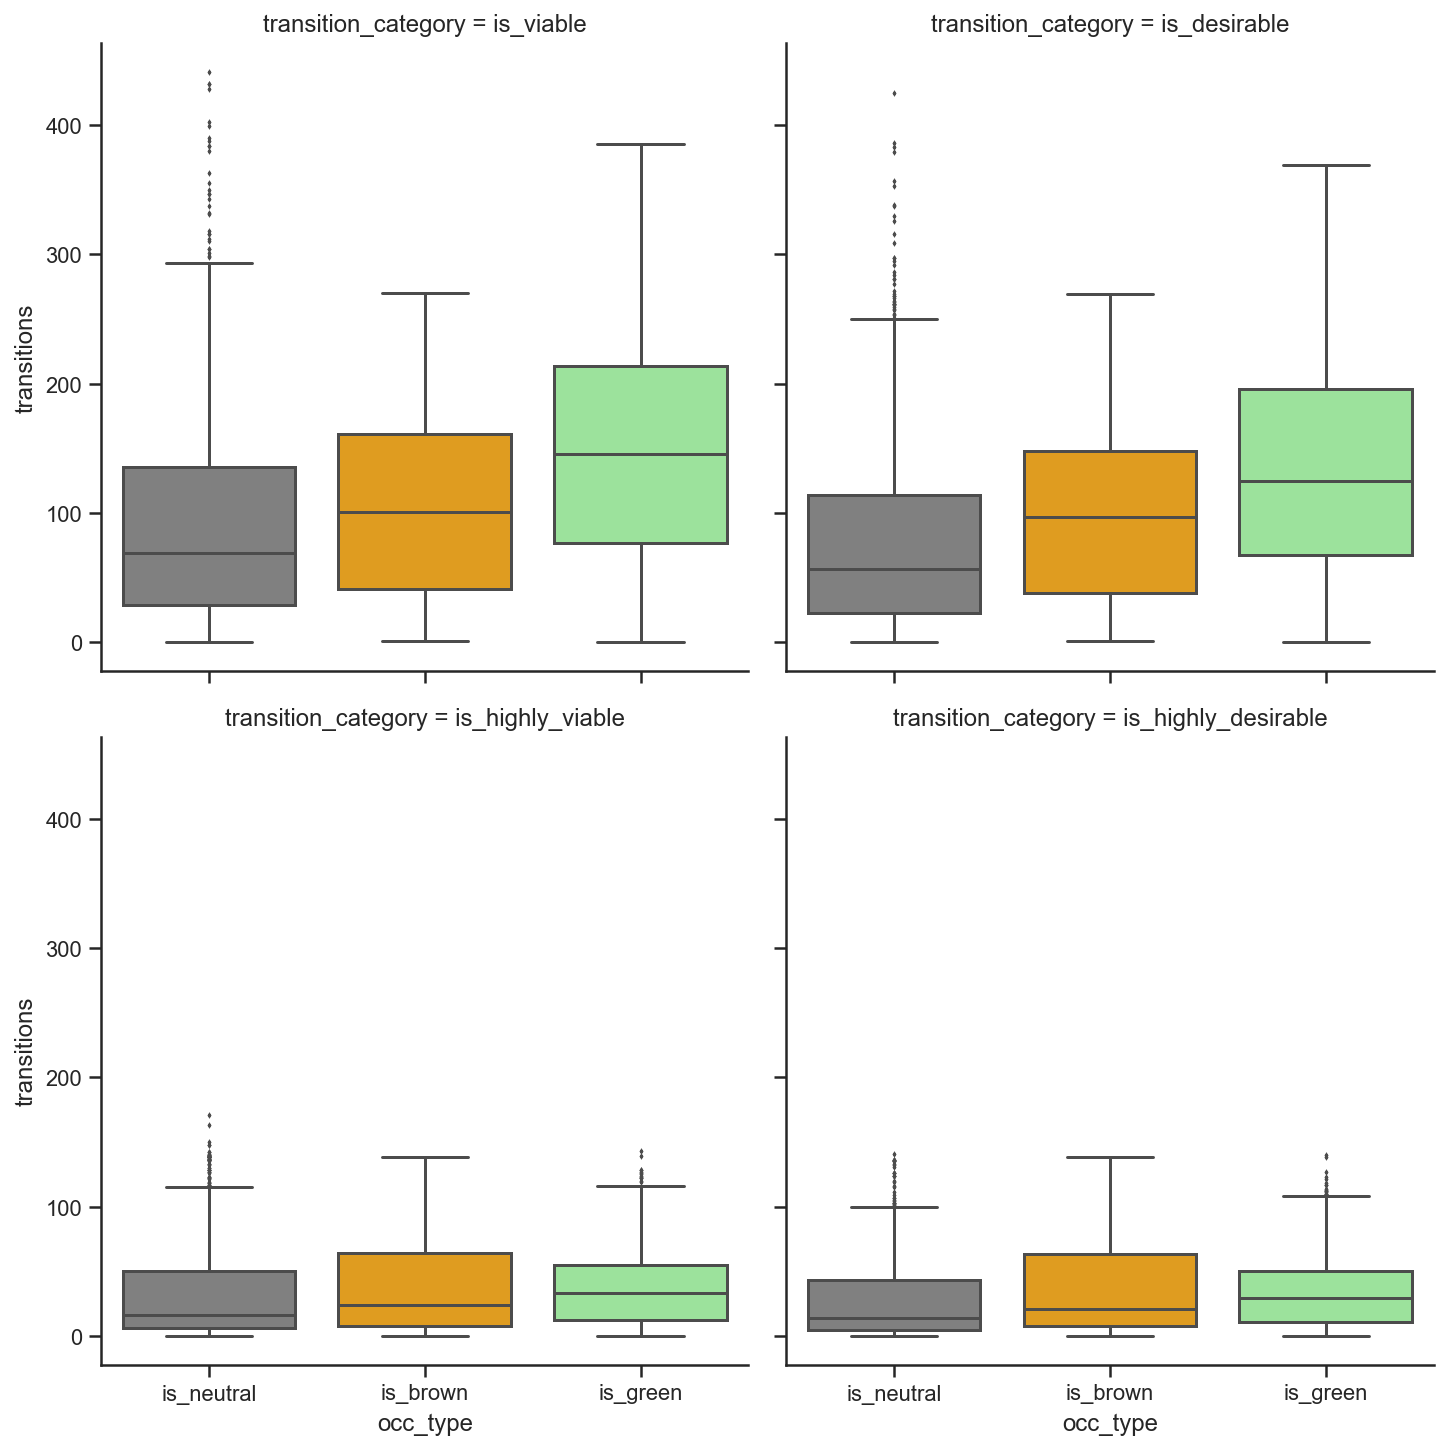

In [137]:
sns.catplot(
    y="transitions",
    x="occ_type",
    col="transition_category",
    col_wrap=2,
    palette=["grey", "orange", "lightgreen"],
    fliersize=1,
    kind="box",
    data=df_metadata_transitions2_long
)

plt.savefig(
    os.path.join(figure_dir, "n_transitions_by_occupation_type_v2.png"),
    dpi=150,
    bbox_inches="tight"
)

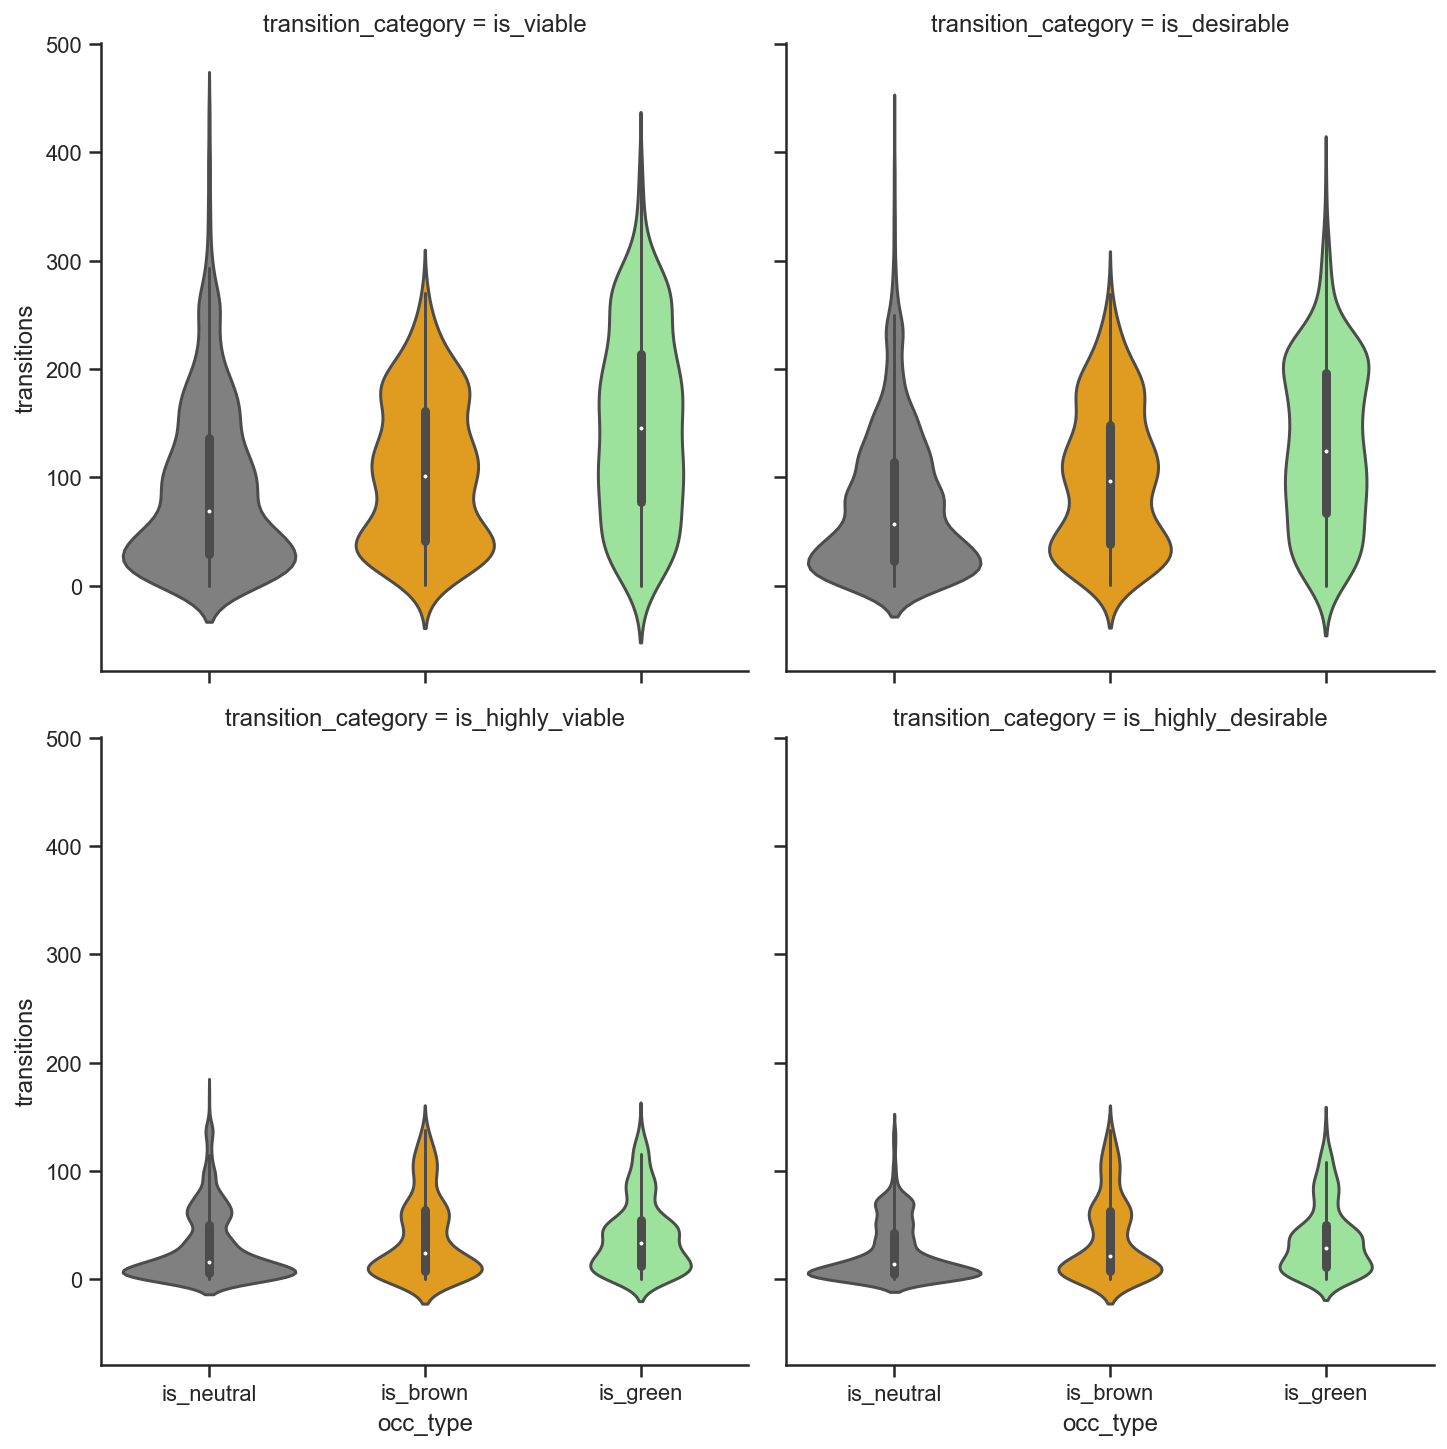

In [138]:
sns.catplot(
    y="transitions",
    x="occ_type",
    col="transition_category",
    col_wrap=2,
    palette=["grey", "orange", "lightgreen"],
    fliersize=1,
    kind="violin",
    data=df_metadata_transitions2_long
)

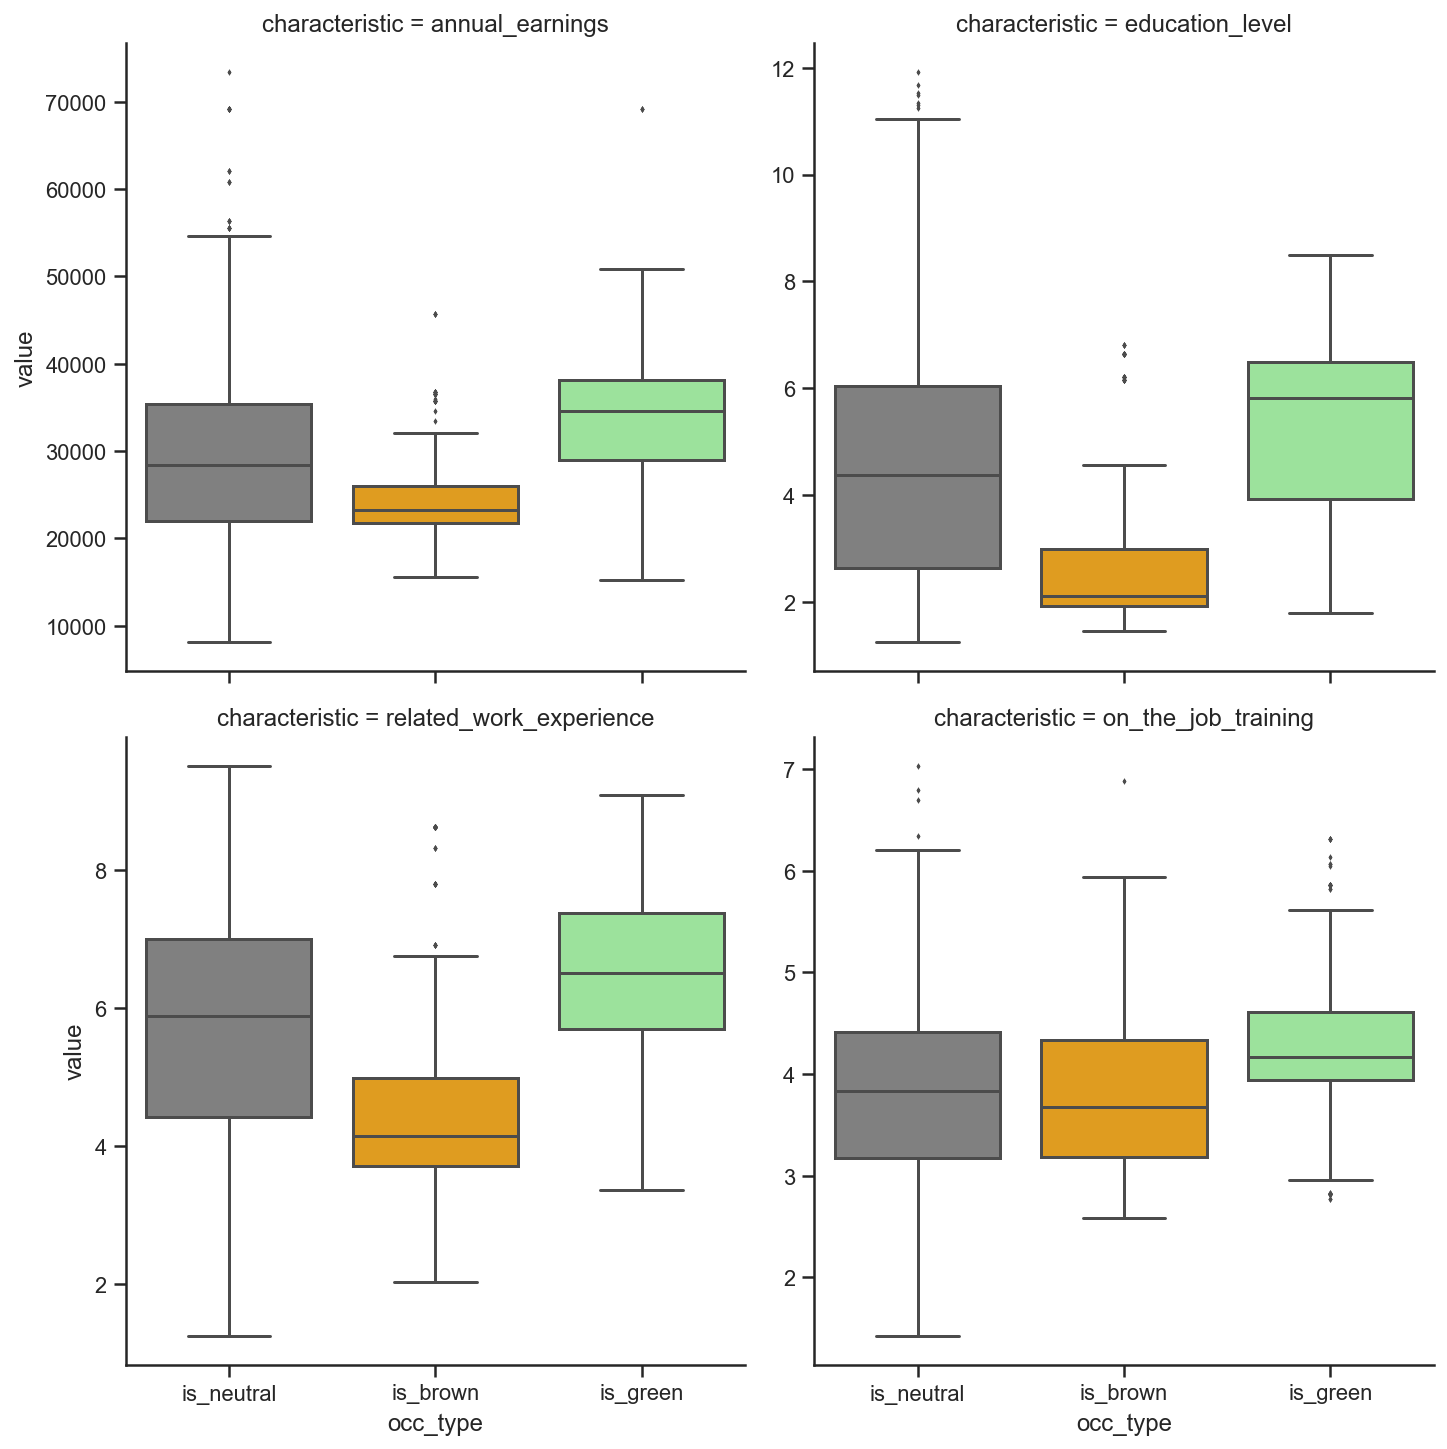

In [140]:
df_metadata_transitions3_long = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["annual_earnings", "education_level", "related_work_experience", "on_the_job_training"],
    value_name="value",
    var_name="characteristic"
)

sns.catplot(
    y="value",
    x="occ_type",
    col="characteristic",
    col_wrap=2,
    palette=["grey", "orange", "lightgreen"],
    fliersize=1,
    kind="box",
    sharey=False,
    data=df_metadata_transitions3_long
)

plt.savefig(
    os.path.join(figure_dir, "educ_pay_by_occupation_type_v2.png"),
    dpi=150,
    bbox_inches="tight"
)

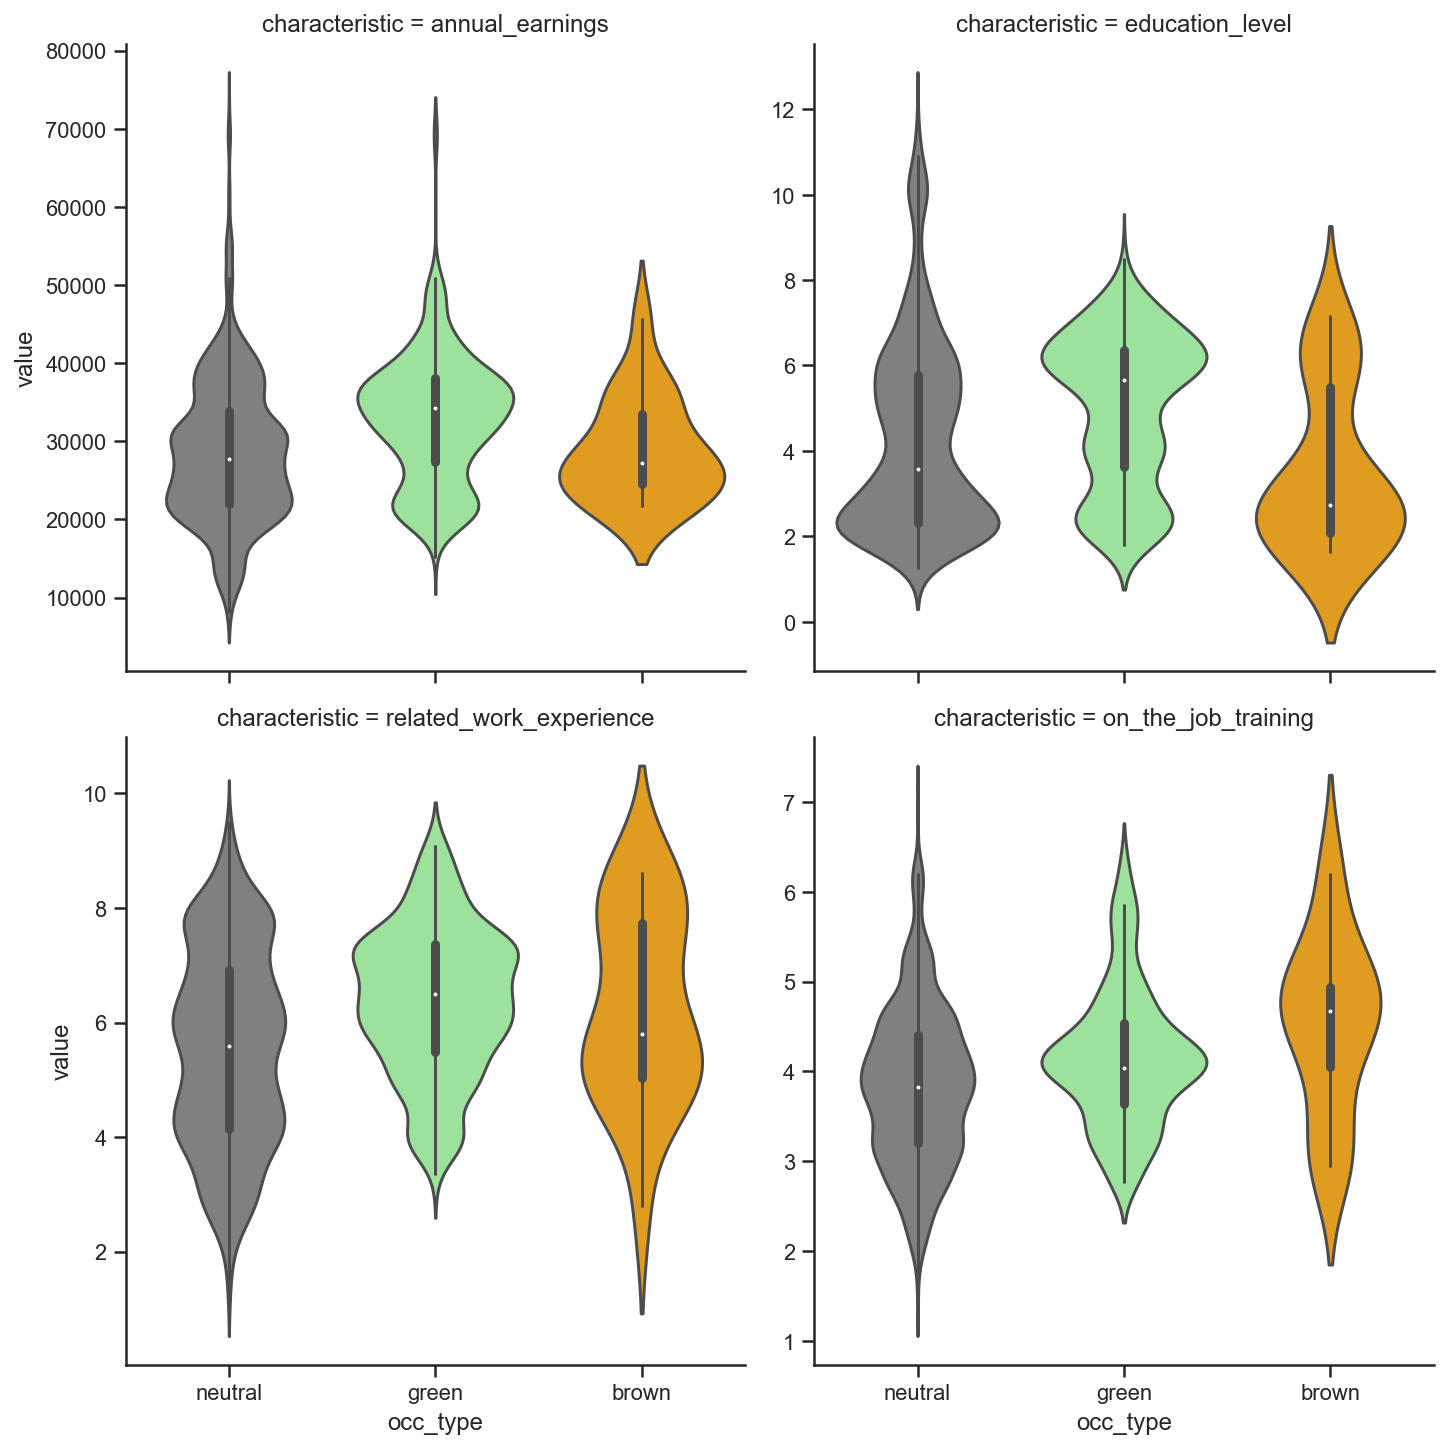

In [40]:
sns.catplot(
    y="value",
    x="occ_type",
    col="characteristic",
    col_wrap=2,
    palette=["grey", "lightgreen", "orange"],
    fliersize=1,
    kind="violin",
    sharey=False,
    data=df_metadata_transitions3_long
)

In [41]:
# t-tests for diff in means
from scipy import stats

stats.ttest_ind(
    df_metadata_transitions2.is_desirable_brown,
    df_metadata_transitions2.is_desirable_green
)

Ttest_indResult(statistic=-39.76150200089598, pvalue=1.9609204862731055e-306)

In [42]:
stats.ttest_ind(
    df_metadata_transitions2.is_desirable_brown,
    df_metadata_transitions2.is_desirable_neutral
)

Ttest_indResult(statistic=-67.1896758795253, pvalue=0.0)

In [43]:
stats.ttest_ind(
    df_metadata_transitions2.is_desirable_green,
    df_metadata_transitions2.is_desirable_neutral
)


Ttest_indResult(statistic=-42.54010261907161, pvalue=0.0)